In [1]:
using Distributed
using DelimitedFiles
using LaTeXStrings

In [2]:
include("Cell_IBM_Library.jl")

 Activating environment at `~/Pinna Nobilis/Computational models/Project.toml`


IBM_gif (generic function with 1 method)

# Functions 

In [3]:
function R_0(p, S0)
    
    γ, λ, μ, β = p #parameters
    
    return λ / (γ*(1+μ/(β*S0)))
    
end

function custom_S0(x, y)
   
    S0 = zeros(x, y)

    for i in 1 : x

        for j in 1 : y

            if (i < 4 || i > 7) && (j < 4 || j > 7)

                S0[i, j] = 1

            end

        end

    end
    
    return S0
    
end

function custom_P0(x, y)
   
    M = zeros(x, y)
    
    M[Int32(x/4), Int32(y/4)] = P0
    M[Int32(3*x/4), Int32(y/4)] = P0
    M[Int32(x/4), Int32(3*y/4)] = P0
    M[Int32(3*x/4), Int32(3*y/4)] = P0
    
    return M
    
end

function plot_config(x, y, S_pos, I_pos, R_pos, P ; max_P=200, ms=6, size=(1000, 800))

    #Plot
    M = reshape(P, (x,y))

    X_S, Y_S = get_xy_positions(M, S_pos)
    X_I, Y_I = get_xy_positions(M, I_pos)
    X_R, Y_R = get_xy_positions(M, R_pos)

    #=
    cmaps = Symbol[:phase,:lightrainbow,:ice,:curl,:matter,:speed,:turbid,:sand_grad,:tempo,
        :solarized_light_grad,:gray,:reds,:blues,:redsblues,:darkrainbow,:viridis,:algae,:greens,:balance,
        :solar,:solarized_grad,:dark_grad,:haline,:oxy,:plasma,:deep,:heat,:magma,:inferno,:rainbow,:orange_grad,
        :bluesreds,:amp,:dense,:darktest,:lime_grad,:grays,:thermal,:delta,:lighttest]
    =#

    heatmap(M, c=:blues, clims=(0, max_P), size=size)

    scatter!(X_S, Y_S, xlim=(0.5, x+0.5), ylim=(0.5, y+0.5), color=:green3, m=:v, ms=ms, label="")
    scatter!(X_I, Y_I, xlim=(0.5, x+0.5), ylim=(0.5, y+0.5), color=:red, m=:v, ms=ms, label="")
    scatter!(X_R, Y_R, xlim=(0.5, x+0.5), ylim=(0.5, y+0.5), color=:black, m=:v, ms=ms, label="")
    
end

function plot_last_config(x, y, S_pos, I_pos, R_pos, P ; max_P=200, ms=6, size=(1000, 800))

    #Plot
    M = reshape(P, (x,y))

    X_S, Y_S = get_xy_positions(M, S_pos)
    X_I, Y_I = get_xy_positions(M, I_pos)
    X_R, Y_R = get_xy_positions(M, R_pos)
    
    Mp = zeros(x, y)
    
    for i in 1 : length(X_S)
       
        Mp[X_S[i], Y_S[i]] = 1
        
    end
    
    for i in 1 : length(X_R)
       
        Mp[X_R[i], Y_R[i]] = -1
        
    end

    #=
    cmaps = Symbol[:phase,:lightrainbow,:ice,:curl,:matter,:speed,:turbid,:sand_grad,:tempo,
        :solarized_light_grad,:gray,:reds,:blues,:redsblues,:darkrainbow,:viridis,:algae,:greens,:balance,
        :solar,:solarized_grad,:dark_grad,:haline,:oxy,:plasma,:deep,:heat,:magma,:inferno,:rainbow,:orange_grad,
        :bluesreds,:amp,:dense,:darktest,:lime_grad,:grays,:thermal,:delta,:lighttest]
    =#

    heatmap(Mp)
    
end

function IBM_avg(t_end, x, y, S0, P0, parameters, method_P, method_S, M, delta_t, filename, limit="")

    avg_t = 0 : delta_t : t_end

    counts = zeros(length(avg_t))

    S_avg = zeros(length(avg_t))
    I_avg = zeros(length(avg_t))
    R_avg = zeros(length(avg_t))
    P_avg = zeros(length(avg_t))
    
    i = 0
    
    if limit == "MF"

        for i in 1 : M

            S, I, R, P, time = IBM_MF(t, x, y, S0, P0, parameters, method_P, method_S)

            for i in eachindex(time)

                for j in 2 : length(avg_t)

                    if avg_t[j-1] < time[i] < avg_t[j]

                        S_avg[j-1] += S[i]
                        I_avg[j-1] += I[i]
                        R_avg[j-1] += R[i]

                        P_avg[j-1] += P[i]

                        counts[j-1] += 1

                        break

                    end

                end

            end
                
        end
        
    else
        
        for i in 1 : M

            S, I, R, P, time = IBM(t, x, y, S0, P0, parameters, method_P, method_S);

            for i in eachindex(time)

                for j in 2 : length(avg_t)

                    if avg_t[j-1] < time[i] < avg_t[j]

                        S_avg[j-1] += S[i]
                        I_avg[j-1] += I[i]
                        R_avg[j-1] += R[i]

                        P_avg[j-1] += P[i]

                        counts[j-1] += 1

                        break

                    end

                end

            end

        end
        
    end

    S_avg, I_avg, R_avg, P_avg = S_avg./counts, I_avg./counts, R_avg./counts, P_avg./counts

    f = open(filename, "w")

    println(f, "#t\tS\tI\tR\tP")

    for i in eachindex(S_avg)

        println(f, avg_t[i], "\t", S_avg[i], "\t", I_avg[i], "\t", R_avg[i], "\t", P_avg[i])

    end

    close(f)

    return S_avg, I_avg, R_avg, P_avg

end

function IBM_avg_survivors(t_end, x, y, S0, P0, parameters, method_P, method_S, M, delta_t, filename, limit="")

    avg_t = 0 : delta_t : t_end

    counts = zeros(length(avg_t))

    S_avg = zeros(length(avg_t))
    I_avg = zeros(length(avg_t))
    R_avg = zeros(length(avg_t))
    P_avg = zeros(length(avg_t))
    
    i = 0
    
    if limit == "MF"

        while i < M

            S, I, R, P, time = IBM_MF(t, x, y, S0, P0, parameters, method_P, method_S)
            
            if length(time) > 100
                
                i += 1

                for i in eachindex(time)

                    for j in 2 : length(avg_t)

                        if avg_t[j-1] < time[i] < avg_t[j]

                            S_avg[j-1] += S[i]
                            I_avg[j-1] += I[i]
                            R_avg[j-1] += R[i]

                            P_avg[j-1] += P[i]

                            counts[j-1] += 1

                            break

                        end

                    end

                end
                
            end

        end
        
    else
        
        while i < M

            S, I, R, P, time = IBM(t, x, y, S0, P0, parameters, method_P, method_S);
            
            if length(time) > 100
                
                i += 1

                for i in eachindex(time)

                    for j in 2 : length(avg_t)

                        if avg_t[j-1] < time[i] < avg_t[j]

                            S_avg[j-1] += S[i]
                            I_avg[j-1] += I[i]
                            R_avg[j-1] += R[i]

                            P_avg[j-1] += P[i]

                            counts[j-1] += 1

                            break

                        end

                    end

                end
                
            end

        end
        
    end

    S_avg, I_avg, R_avg, P_avg = S_avg./counts, I_avg./counts, R_avg./counts, P_avg./counts

    f = open(filename, "w")

    println(f, "#t\tS\tI\tR\tP")

    for i in eachindex(S_avg)

        println(f, avg_t[i], "\t", S_avg[i], "\t", I_avg[i], "\t", R_avg[i], "\t", P_avg[i])

    end

    close(f)

    return S_avg, I_avg, R_avg, P_avg

end

function phase_transition_parallel(t_end, x, y, S0, P0, parameters, method_P, method_S, kappas, M ; filename="R_vs_κ.txt")
    
    if method_S == "custom"
       
        S0 = sum(S0)
        
    end
    
    f = open("R_vs_κ_N_$x.txt", "w")
    
    println(f, "#κ\t<R>_∞\tσ^2")
    
    for κ in kappas
        
        parameters[end] = κ
        
        result_k = SharedArray{Float64}(2)
        
        @sync @distributed for i in 1 : M
        
            R_f = IBM_R_inf(t_end, x, y, S0, P0, parameters, method_P, method_S)
            
            result_k[1] += (1-R_f)
            result_k[2] += (1-R_f)^2
            
        end
        
        μ = result_k[1] / M
        
        σ = result_k[2] / M - μ^2
        
        println(f, κ, "\t", μ, "\t", sqrt(σ/M))
        
        println(κ, "\t", μ, "\t", sqrt(σ/M))
        
    end
    
    close(f)
    
end

phase_transition_parallel (generic function with 1 method)

# Initial configuration plot

In [ ]:
x = 50
y = 50

S0 = x*y

P0 = 100

parameters = [1, 5, 1, 1.0, 0.0] # γ, λ, μ, β, κ

method_P = "center"

method_S = "rand"

if method_S == "custom"

    S0 = custom_S0(x, y)
    
end


S_pos, I_pos, R_pos, P = init_layers(x, y, S0, P0, method_P, method_S)

plot_config(x, y, S_pos, I_pos, R_pos, P)

In [ ]:
#savefig("S_custom_init_config.png")

# Mean Field

In [ ]:
t = 20

x = 50
y = 50

S0 = x*y

P0 = 5

parameters = [1.0, 5.0, 1.0, 0.02, 0.0] # γ, λ, μ, β, κ

method_P = "rand"
method_S = "rand"

println("R_0=", R_0(parameters, S0)) #R_0 value for this parameters

S, I, R, P, time = @time IBM_MF(t, x, y, S0, P0, parameters, method_P, method_S);

In [ ]:
f = open("large_system.txt", "w")

println(f, "#t\tS\tI\tR\tP")

for i in eachindex(S)

    println(f, time[i], "\t", S[i], "\t", I[i], "\t", R[i], "\t", P[i])

end

close(f)

In [ ]:
#p1 = plot(time, [P λ*I/μ], color=[:deepskyblue :hotpink], lw=3, label=[L"P" L"P_{\textrm{approx}}"])
p1 = plot(time, P, color=:deepskyblue, lw=3, label=L"P")

p2 = plot(time, [S I R], color=[:green3 :red :black], lw=3, label=[L"S" L"I" L"R"])

plot(p1, p2, size=(1000, 500), xticks=1:1:20, legendfont=16)

#savefig("single_μ_$μ.png")
#savefig("single_realisation_N_100.png")

In [ ]:
M = 10
delta_t = 0.1

filename = "prova.txt"

limit="MF"

S_avg, I_avg, R_avg, P_avg = @time IBM_avg(t, x, y, N, P0, parameters, method_P, M, delta_t, filename, limit)

In [ ]:
plot(P_avg)

# No MF 

In [ ]:
t = 50

x = 50
y = 50

S0 = x*y

P0 = 50

parameters = [1.0, 50, 1, 1, 1.0] # γ, λ, μ, β, κ

method_P = "center"

method_S = "rand"

if method_S == "custom"

    S0 = custom_S0(x, y)
    
    println("R_0=", R_0(parameters, sum(S0))) #R_0 value for this parameters
    
else

    println("R_0=", R_0(parameters, S0)) #R_0 value for this parameters
    
end

S, I, R, P, time = @time IBM(t, x, y, S0, P0, parameters, method_P, method_S);

In [ ]:
#p1 = plot(time, [P 500*I/100], color=[:deepskyblue :hotpink], lw=3, label=[L"P" L"P_{\textrm{approx}}"])
p1 = plot(time, P, color=:deepskyblue, lw=3, label=L"P")

#p2 = plot(time, [P./I ones(length(time))*5], lw=3, label=[L"P/I" L"\lambda/\mu"])
p2 = plot(time, [S I R], color=[:green3 :red :black], lw=3, label=[L"S" L"I" L"R"])

plot(p1, p2, size=(1000, 500), legendfont=16)

#savefig("P_approx_big_system.png")
#savefig("single_realisation_N_100.png")

In [12]:
t = 1000

x = 100
y = 100

S0 = x*y

P0 = 50

parameters = [1.0, 50, 1, 1, 1.05] # γ, λ, μ, β, κ

method_P = "center"

method_S = "rand"

if method_S == "custom"

    S0 = custom_S0(x, y)
    
    println("R_0=", R_0(parameters, sum(S0))) #R_0 value for this parameters
    
else

    println("R_0=", R_0(parameters, S0)) #R_0 value for this parameters
    
end


S_pos, I_pos, R_pos, P = @time IBM_fast(t, x, y, S0, P0, parameters, method_P, method_S);

R_0=49.99500049995
3369.828256 seconds (39.35 G allocations: 665.602 GiB, 9.93% gc time)


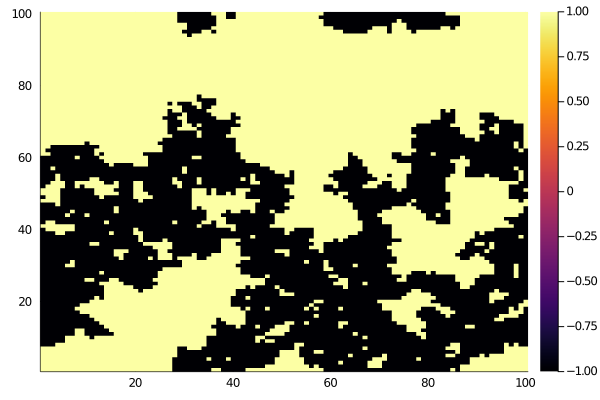

In [13]:
plot_last_config(x, y, S_pos, I_pos, R_pos, P)

#savefig("small_clustering.png")

In [14]:
savefig("clustering_N_10000.png")

# Phase transition 

In [ ]:
t = 1000

x = 15
y = 15

S0 = x*y

P0 = 50

parameters = [1.0, 50, 1, 1, 1.0] # γ, λ, μ, β, κ

method_P = "center"

method_S = "rand"

M = 100

kappas = 0.02 : 0.02 : 2.0

if method_S == "custom"

    S0 = custom_S0(x, y)
    
    println("R_0=", R_0(parameters, sum(S0))) #R_0 value for this parameters
    
else

    println("R_0=", R_0(parameters, S0)) #R_0 value for this parameters
    
end

In [ ]:
@time phase_transition_parallel(t, x, y, S0, P0, parameters, method_P, method_S, kappas, M)

In [ ]:
data, header = readdlm("Cell/Patterns/R_vs_κ_N_10.txt", header=true)

In [ ]:
plot(data[:, 1], data[:, 2], ribbon=data[:, 3], label="", xlabel=L"\kappa", ylabel=L"<R>_\infty",
labelfontsize=20, size=(800, 600))

vline!([data[argmax(data[:, 3]), 1]], label="Critical point", lw=2, legend=:topleft, legendfont=14)

#savefig("phase_transition.png")

In [ ]:
plot(data[:, 1], data[:, 3].^2 .* 100, lw=2,  xlabel=L"\kappa", ylabel=L"<R^2>-<R>^2", label="",
 labelfontsize=20, size=(900, 600))

vline!([data[argmax(data[:, 3]), 1]], label="Critical point", lw=2, legendfont=14, legend=:topleft)

#savefig("susceptibility.png")

# IBM animation

In [ ]:
t = 1000

x = 100
y = 100

S0 = x*y

P0 = 50

parameters = [1.0, 50, 1, 1, 1.05] # γ, λ, μ, β, κ

method_P = "center"

method_S = "rand"

#clims = (0, 50)

if method_S == "custom"

    S0 = custom_S0(x, y)
    
    println("R_0=", R_0(parameters, sum(S0))) #R_0 value for this parameters
    
else

    println("R_0=", R_0(parameters, S0)) #R_0 value for this parameters
    
end

println("\nComputing animation...")

anim = @time IBM_animation_fast(t, x, y, S0, P0, parameters, method_P, method_S; every_frame=100, ms=6, clims=(0, 100));

println("\nSaving animation...")

#name = string("IBM_cell_anim_P_", P0, "_N_", sum(S0), "_equidistant.mp4")

name = string("N_", S0, "_clustering_κ_c.mp4")

@time gif(anim, name, fps = 100)